# Compare A Fit to $t^{1/2}$ to the Epstein - Plesset Model Prediction

Given that bubbles tend to grow as $R \propto t^{1/2}$ and the Epstein - Plesset model of their growth also follows $t^{1/2}$ dynamics as well, I am curious how the two models differ in their predictions of the nucleation time. While they likely predict very different dynamics over long time periods due to the effects of interfacial tension and pressure, I expect that even if the effect is fractionally large, the short time scale predicted by Epstein - Plesset between nucleation and observation means that the absolute effect may be negligible.

If I could use a $t^{1/2}$ fit to estimate the nucleation time instead, I could avoid some of the numerical instabilities I am running into near the phase transition temperature of CO$_2$.

In [56]:
%load_ext autoreload
%autoreload 2

# sets plotting font to Arial
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

# standard libraries
import os
import glob
import pickle as pkl

# 3rd party libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

# custom libraries
import sys
sys.path.append('../../libs/')
import fn
import flow
import plot.bubble as pltb
from conversions import *

# comes after imports from ../../libs/ because I unfortunately 
# created files with the same name there and in ../src/
sys.path.append('../src/')
import objproc as op
import bubble
import analytics as an

### PARAMETERS ###
# directory template containing data files
data_dir_tmp = '../input/ppg_co2/testing/*'
# data filename
data_filename = 'data.pkl'
# data for polyol-CO2 mixture 
# make this on Wang group server with `bi_surf`--read README.txt and copy 1k3f_22c.csv
polyol_data_file = '../input/3k2f_31c.csv'
# equation of state data for CO2 at desired temperature 
eos_co2_file = '../input/eos_co2_25-0C.csv'
# save directory for E-P data
save_path = '../output/debug_fit_fn.pkl' #20211202_72bar_test_ep.pkl'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Epstein - Plesset Fit

I fit the Epstein - Plesset model of bubble growth to an example bubble growth trajectory. I allow the effective diffusivity $\mathcal{D}$ and nucleation time $t_{nuc}$ to vary.

In [57]:
# fits Epstein - Plesset model
# GROWTH MODEL PARAMETERS
growth_fn = bubble.grow
dt = 1E-10 # [s]
R_nuc = 3E-9 # higher value bypasses numerical challenges at nm scale [m]

# FITTING PARAMETERS
frac_lo = 0.95
frac_hi = 1.05
# guess for effective diffusivity constant [m^2/s]
D_lo = 5E-9
D_hi = 1.5E-8
err_tol = 0.003
err_fn = an.calc_abs_sgn_mse
rms_tol = -0.02 # keep high--this is used to fit D, must allow for noise in data
exp_ratio_tol = 0.01
fit_fn_params = {}
save_freq = 1

# PLOTTING PARAMETERS
x_lim = [1E-2, 10]
y_lim = [1, 30]

# USER PARAMETERS
n_fit = 1

# globs list of data directories
data_dir_list = glob.glob(data_dir_tmp)

# fits effective diffusivity D and nucleation time t_nuc
data = an.fit_D_t_nuc(data_filename, data_dir_list, polyol_data_file,
                        eos_co2_file, frac_lo, frac_hi,
                        D_lo, D_hi, growth_fn, dt, R_nuc, fit_fn_params,
                        exp_ratio_tol, n_fit=n_fit, show_plots=True,
                            save_path=save_path, save_freq=save_freq)

11 R =  3.877837030746723 v =  0.8717492145038968  vs.  0.6951621573622259
12 R =  4.165953693460643 v =  0.42910894972254043  vs.  0.6951621573622259
15 R =  4.165953693460643 v =  1.317459335944246  vs.  0.6951621573622259
23 R =  5.113692174949114 v =  0.6211162099731206  vs.  0.6951621573622259
28 R =  3.877837030746723 v =  0.8511351674141512  vs.  0.6951621573622259
32 R =  4.946581428972157 v =  1.3750060509628275  vs.  0.6951621573622259
50 R =  3.3368847308126526 v =  0.9796976363138722  vs.  0.6951621573622259
55 R =  5.21563698894391 v =  1.252515780114938  vs.  0.6951621573622259
59 R =  4.1974268011115665 v =  0.6870410040354897  vs.  0.6951621573622259
60 R =  3.3368847308126526 v =  0.24043313478058947  vs.  0.6951621573622259
72 R =  4.29587465532342 v =  1.4647829910714534  vs.  0.6951621573622259
79 R =  5.459348274707441 v =  1.1527834646311317  vs.  0.6951621573622259
83 R =  6.12067373411023 v =  0.7407429153299547  vs.  0.6951621573622259
89 R =  5.299389544119005

KeyboardInterrupt: 

In [45]:
load_path = '../output/20211202_72bar_21-32_35-74.pkl'

with open(load_path, 'rb') as f:
    data = pkl.load(f)

# defines functional form of square-root fit
def sqrt_fit(t, D, t_nuc):
    """Square-root fit R(t) = sqrt(D*(t - t_nuc))."""
    return np.sqrt(D*(np.abs(t - t_nuc)))

def compare_ep_sqrt(t_nuc_ep, t_fit_ep, R_fit_ep, t_nuc_sqrt, t_fit_sqrt, R_fit_sqrt, t_bub, R_bub, 
                   lw=2, ax_fs=16, tk_fs=14, l_fs=12, x_lim=None, y_lim=None):
    """Compares predictions by Epstein - Plesset fit and t^1/2 fit against data."""
    # plots comparison of square-root fit and Epstein - Plesset model alongside true bubble growth data
    # creates figure
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # plots data
    ax.plot(np.asarray(t_fit_ep - t_nuc_ep)*s_2_ms, np.asarray(R_fit_ep)*m_2_um, 
            'r--', lw=lw, label='E - P')
    ax.plot(np.asarray(t_fit_sqrt - t_nuc_sqrt)*s_2_ms, np.asarray(R_fit_sqrt)*m_2_um, 
            'b', lw=lw, label=r'$\propto t^{1/2}$')
    ax.plot((t_bub - t_nuc_ep)*s_2_ms, R_bub*m_2_um, 'k', lw=0, 
            marker='o', fillstyle='none', label='data (E-P)')
    ax.plot((t_bub - t_nuc_sqrt)*s_2_ms, R_bub*m_2_um, 'k', lw=0, 
            marker='^', fillstyle='none', label=r'data ($t^{1/2}$)')

    # formats plot
    ax.set_xlabel(r'$t - t_{nuc}$ [ms]', fontsize=ax_fs)
    ax.set_ylabel(r'$R(t)$ [$\mu$m]', fontsize=ax_fs)
    ax.tick_params(axis='both', labelsize=tk_fs)
    ax.legend(fontsize=l_fs)
    ax.set_xscale('log')
    ax.set_yscale('log')
    if x_lim:
        ax.set_xlim(x_lim)
    if y_lim:
        ax.set_ylim(y_lim)
    
    return ax

Plots differences in Epstein - Plesset and $t^{1/2}$ predictions.

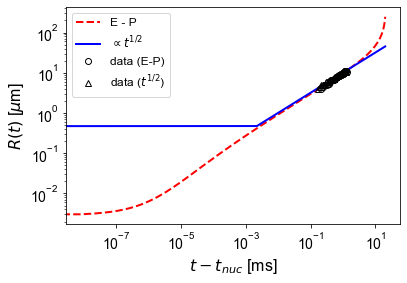

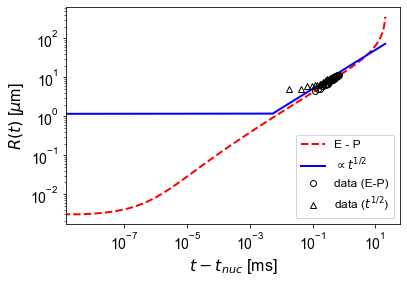

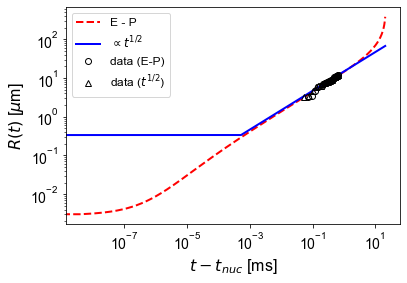

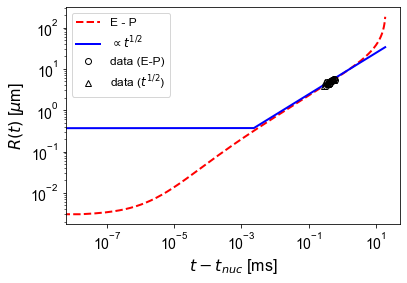

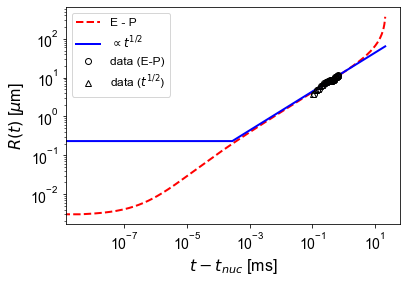

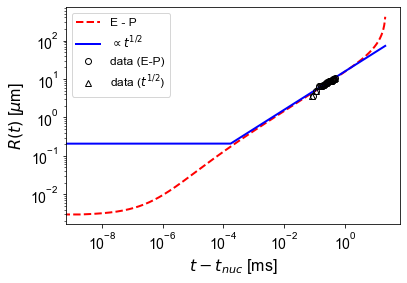

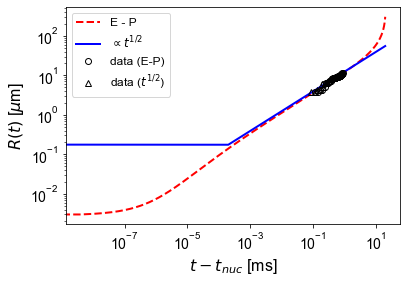

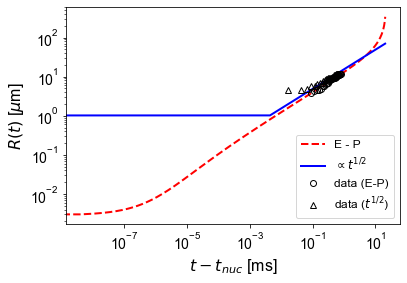

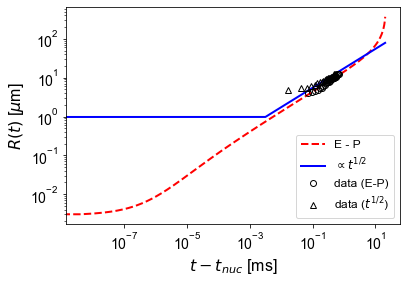

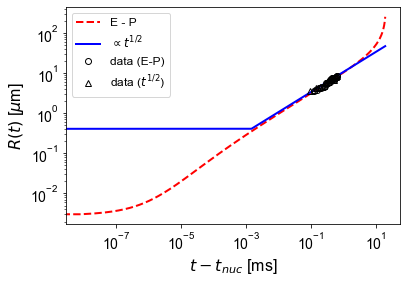

In [39]:
n_plot = 10
x_lim = None # [1E-5, 10]
y_lim = None # [1E-1, 100]
# extracts fit data
ct = 0
for vid_num in data.keys():
    vid_data = data[vid_num]['data']
    for bub_num in vid_data.keys():
        bub_data = vid_data[bub_num]
        # extracts fit data
        t_fit_ep = bub_data['t_fit']
        R_fit_ep = bub_data['R_fit']
        t_bub = bub_data['t_bub']
        R_bub = bub_data['R_bub']
        D_ep = bub_data['D']
        t_nuc_ep = bub_data['t_nuc']
        
        # fits square-root function to bubble growth data
        try:
            popt, pcov = scipy.optimize.curve_fit(sqrt_fit, t_bub, R_bub, p0=[D_ep, t_nuc_ep])
        except:
            print('Failed to fit data')
            continue
        D_sqrt, t_nuc_sqrt = popt
        # computes predictions of fit
        t_fit_sqrt = t_fit_ep
        R_fit_sqrt = sqrt_fit(t_fit_sqrt, *popt)
        
        # plots differences in predictions
        compare_ep_sqrt(t_fit_ep, R_fit_ep, t_fit_sqrt, R_fit_sqrt, 
                       t_bub, R_bub, x_lim=x_lim, y_lim=y_lim)
        
        ct += 1
        if ct == n_plot:
            break
            
    if ct == n_plot:
        break

C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


Failed to fit data


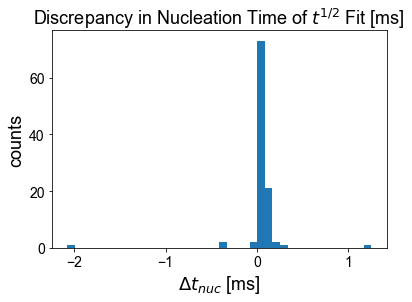

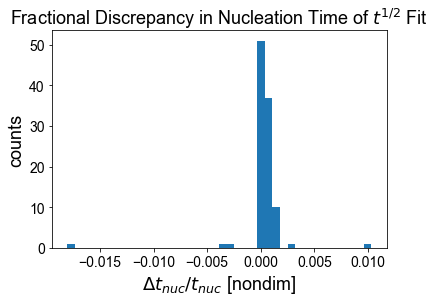

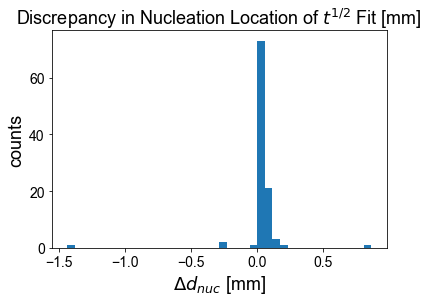

In [40]:
# plot parameters
n_bins = 40
t_fs = 18
ax_fs = 18
tk_fs = 14

dt_nuc = []
dt_nuc_frac = []
dd_nuc = []

# extracts fit data
for vid_num in data.keys():
    vid_data = data[vid_num]['data']
    v = data[vid_num]['metadata']['v_max']
    for bub_num in vid_data.keys():
        bub_data = vid_data[bub_num]
        # extracts fit data
        t_fit_ep = bub_data['t_fit']
        R_fit_ep = bub_data['R_fit']
        t_bub = bub_data['t_bub']
        R_bub = bub_data['R_bub']
        D_ep = bub_data['D']
        t_nuc_ep = bub_data['t_nuc']
        
        # fits square-root function to bubble growth data
        try:
            popt, pcov = scipy.optimize.curve_fit(sqrt_fit, t_bub, R_bub, p0=[D_ep, t_nuc_ep])
        except:
            print('Failed to fit data')
            continue
        D_sqrt, t_nuc_sqrt = popt
        # computes predictions of fit
        t_fit_sqrt = t_fit_ep
        R_fit_sqrt = sqrt_fit(t_fit_sqrt, *popt)
        
        # computes discrepancy in nucleation time prediction
        dt_nuc += [t_nuc_sqrt - t_nuc_ep]
        dt_nuc_frac += [(t_nuc_sqrt - t_nuc_ep) / t_nuc_ep]
        
        # computes discrepancy in nucleation location
        d_nuc_sqrt = v*t_nuc_sqrt
        d_nuc_ep = v*t_nuc_ep
        dd_nuc += [d_nuc_sqrt - d_nuc_ep]

        
# plots distribution of discrepancies in nucleation time
plt.figure()
plt.hist(np.asarray(dt_nuc)*s_2_ms, bins=n_bins)
plt.title(r'Discrepancy in Nucleation Time of $t^{1/2}$ Fit [ms]', fontsize=t_fs)
plt.xlabel(r'$\Delta t_{nuc}$ [ms]', fontsize=ax_fs)
plt.ylabel('counts', fontsize=ax_fs)
plt.tick_params(axis='both', labelsize=tk_fs)

plt.figure()
plt.hist(dt_nuc_frac, bins=n_bins)
plt.title(r'Fractional Discrepancy in Nucleation Time of $t^{1/2}$ Fit', fontsize=t_fs)
plt.xlabel(r'$\Delta t_{nuc} / t_{nuc}$ [nondim]', fontsize=ax_fs)
plt.ylabel('counts', fontsize=ax_fs)
plt.tick_params(axis='both', labelsize=tk_fs)

# plots distribution of discrepancies in nucleation location
plt.figure()
plt.hist(np.asarray(dd_nuc)*m_2_mm, bins=n_bins)
plt.title(r'Discrepancy in Nucleation Location of $t^{1/2}$ Fit [mm]', fontsize=t_fs)
plt.xlabel(r'$\Delta d_{nuc}$ [mm]', fontsize=ax_fs)
plt.ylabel('counts', fontsize=ax_fs)
plt.tick_params(axis='both', labelsize=tk_fs)

### Predict Nucleation Time with $t^{1/2}$ Fit

Having shown that the $t^{1/2}$ fit describes early bubble growth from nucleation within experimental uncertainty, we can use it to estimate the nucleation time with confidence. Below, we apply this technique to predict the nucleation time for a few bubbles.

In [41]:
# fits Epstein - Plesset model
save_path = '../output/20211202_72bar_sqrt.pkl'
# GROWTH MODEL PARAMETERS
growth_fn = bubble.sqrt_fit
dt = 1E-9 # [s]
R_nuc = 3E-9 # higher value bypasses numerical challenges at nm scale [m]

# FITTING PARAMETERS
frac_lo = 0.95
frac_hi = 1.05
# guess for effective diffusivity constant [m^2/s]
D_lo = 1E-9
D_hi = 1E-8
err_tol = 0.003
err_fn = an.calc_abs_sgn_mse
rms_tol = -0.02 # keep high--this is used to fit D, must allow for noise in data
exp_ratio_tol = 0.01
fit_fn_params = {}
save_freq = 1
fit_proc = an.scipy_param_fit

# PLOTTING PARAMETERS
# x_lim = [1E-2, 10]
# y_lim = [1, 30]

# USER PARAMETERS
n_fit = -1

# globs list of data directories
data_dir_list = glob.glob(data_dir_tmp)

# fits effective diffusivity D and nucleation time t_nuc
data = an.fit_D_t_nuc(data_filename, data_dir_list, polyol_data_file,
                        eos_co2_file, frac_lo, frac_hi,
                        D_lo, D_hi, growth_fn, dt, R_nuc, fit_fn_params,
                        exp_ratio_tol, n_fit=n_fit, show_plots=False,
                        save_path=save_path, save_freq=save_freq, fit_proc=fit_proc)

11 R =  3.877837030746723 v =  0.8717492145038968  vs.  0.6951621573622259
12 R =  4.165953693460643 v =  0.42910894972254043  vs.  0.6951621573622259
15 R =  4.165953693460643 v =  1.317459335944246  vs.  0.6951621573622259
23 R =  5.113692174949114 v =  0.6211162099731206  vs.  0.6951621573622259
28 R =  3.877837030746723 v =  0.8511351674141512  vs.  0.6951621573622259
32 R =  4.946581428972157 v =  1.3750060509628275  vs.  0.6951621573622259
50 R =  3.3368847308126526 v =  0.9796976363138722  vs.  0.6951621573622259
55 R =  5.21563698894391 v =  1.252515780114938  vs.  0.6951621573622259
59 R =  4.1974268011115665 v =  0.6870410040354897  vs.  0.6951621573622259
60 R =  3.3368847308126526 v =  0.24043313478058947  vs.  0.6951621573622259
72 R =  4.29587465532342 v =  1.4647829910714534  vs.  0.6951621573622259
79 R =  5.459348274707441 v =  1.1527834646311317  vs.  0.6951621573622259
83 R =  6.12067373411023 v =  0.7407429153299547  vs.  0.6951621573622259
89 R =  5.299389544119005

### Try Using Shooting Method and Binary Search for Square-root Fit

Hopefully this gives better accuracy.

In [53]:
data_dir = '../output'

# fits Epstein - Plesset model
save_path_sqrt = os.path.join(data_dir, '20211202_72bar_test_sqrt.pkl')
# GROWTH MODEL PARAMETERS
growth_fn = bubble.sqrt_fit
dt = 1E-7 # [s]
R_nuc = 3E-9 # higher value bypasses numerical challenges at nm scale [m]

# FITTING PARAMETERS
frac_lo = 0.95
frac_hi = 1.03
# guess for effective diffusivity constant [m^2/s]
D_lo = 1E-9
D_hi = 1E-8
err_tol = 0.003
err_fn = an.calc_abs_sgn_mse
rms_tol = -0.02 # keep high--this is used to fit D, must allow for noise in data
exp_ratio_tol = 0.01
fit_fn_params = {}#{'maxfev' : 100000}
save_freq = 1
fit_fn = an.fit_growth_to_pts

# fits effective diffusivity D and nucleation time t_nuc
data_sqrt = an.fit_D_t_nuc(data_filename, data_dir_list, polyol_data_file,
                        eos_co2_file, frac_lo, frac_hi,
                        D_lo, D_hi, growth_fn, dt, R_nuc, fit_fn_params,
                        exp_ratio_tol, show_plots=True,
                        save_path=save_path_sqrt, save_freq=save_freq, fit_fn=fit_fn)

11 R =  3.877837030746723 v =  0.8717492145038968  vs.  0.6951621573622259
12 R =  4.165953693460643 v =  0.42910894972254043  vs.  0.6951621573622259
15 R =  4.165953693460643 v =  1.317459335944246  vs.  0.6951621573622259
23 R =  5.113692174949114 v =  0.6211162099731206  vs.  0.6951621573622259
28 R =  3.877837030746723 v =  0.8511351674141512  vs.  0.6951621573622259
32 R =  4.946581428972157 v =  1.3750060509628275  vs.  0.6951621573622259
50 R =  3.3368847308126526 v =  0.9796976363138722  vs.  0.6951621573622259
55 R =  5.21563698894391 v =  1.252515780114938  vs.  0.6951621573622259
59 R =  4.1974268011115665 v =  0.6870410040354897  vs.  0.6951621573622259
60 R =  3.3368847308126526 v =  0.24043313478058947  vs.  0.6951621573622259
72 R =  4.29587465532342 v =  1.4647829910714534  vs.  0.6951621573622259
79 R =  5.459348274707441 v =  1.1527834646311317  vs.  0.6951621573622259
83 R =  6.12067373411023 v =  0.7407429153299547  vs.  0.6951621573622259
89 R =  5.299389544119005

TypeError: sqrt_fit() got multiple values for argument 'D'

In [43]:
with open(os.path.join(data_dir, '20211202_72bar_test_ep.pkl'), 'rb') as f:
    data_ep = pkl.load(f)

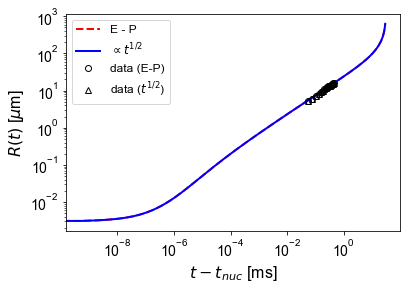

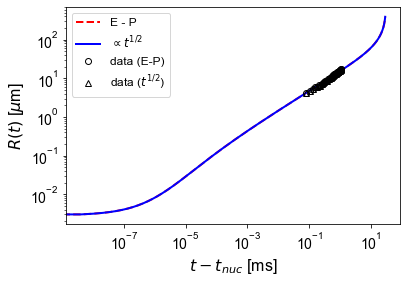

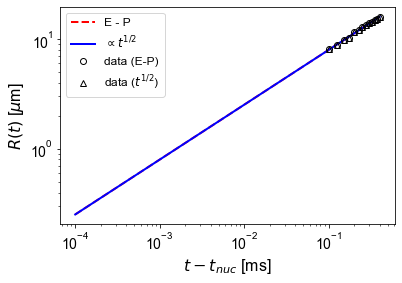

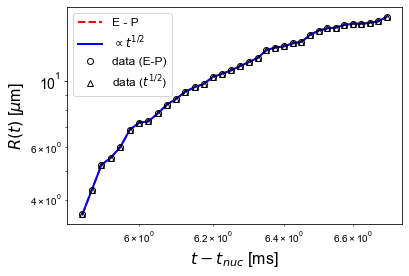

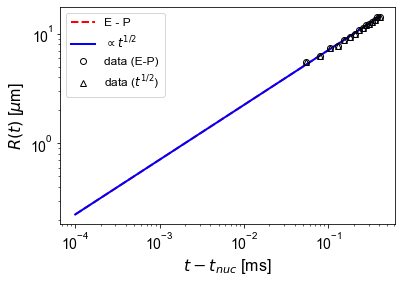

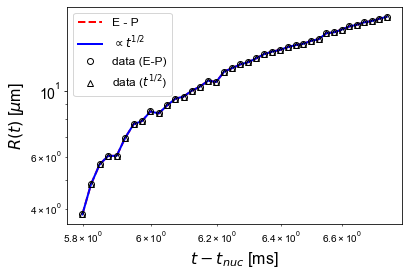

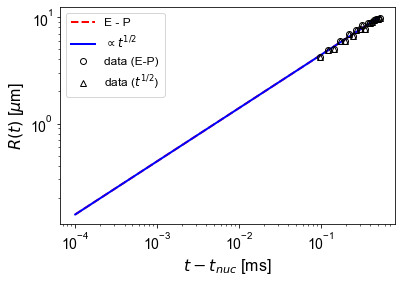

In [46]:
n_plot = 10
x_lim = None # [1E-5, 10]
y_lim = None # [1E-1, 100]
# extracts fit data
ct = 0
for vid_num in data_ep.keys():
    v_ep = data_ep[vid_num]['data']
    v_sqrt = data_sqrt[vid_num]['data']
    for bub_num in v_ep.keys():
        # gets bubble data for each fit method
        bub_ep = v_ep[bub_num]
        bub_sqrt = v_sqrt[bub_num]
        
        # extracts measured bubble data
        t_bub = bub_ep['t_bub']
        R_bub = bub_ep['R_bub']
        # extracts E-P fit data
        t_nuc_ep = bub_ep['t_nuc']
        t_fit_ep = bub_ep['t_fit']
        R_fit_ep = bub_ep['R_fit']
        D_ep = bub_ep['D']
        t_nuc_ep = bub_ep['t_nuc']
        # extracts sqrt fit data
        t_nuc_sqrt = bub_sqrt['t_nuc']
        t_fit_sqrt = bub_sqrt['t_fit']
        R_fit_sqrt = bub_sqrt['R_fit']
    
        # plots differences in predictions
        compare_ep_sqrt(t_nuc_ep, t_fit_ep, R_fit_ep, t_nuc_sqrt, t_fit_sqrt, R_fit_sqrt, 
                       t_bub, R_bub, x_lim=x_lim, y_lim=y_lim)
        
        ct += 1
        if ct == n_plot:
            break
            
    if ct == n_plot:
        break